### imports

In [17]:
import matplotlib as plt
from openai import OpenAI
import random
import os
from PIL import Image
import io
import base64
import json
from tqdm import tqdm
import re

### helper functions (extracting code, questions, answers, choices)

In [18]:
def extract_code(response):
    # Look for code blocks delimited by ```python and ```
    code_pattern = re.compile(r'```python(.*?)```', re.DOTALL)
    matches = code_pattern.findall(response)
    # Join all matches into a single string of code
    return '\n'.join(matches).strip()
        
def extract_question_and_answer(script):
    # Extract question marked by <<<QUESTION>>>
    question_match = re.search(r'<<<QUESTION>>>\s*(.*?)<<<CHOICES>>>', script, re.DOTALL)
    question = question_match.group(1).strip() if question_match else None
    
    # Extracting the choices
    choices_match = re.search(r'<<<CHOICES>>>\s*(.*?)<<<CHOICES>>>', script, re.DOTALL)
    choices_str = choices_match.group(1).strip() if choices_match else None
    """
    question_match = re.search(r'<<<QUESTION>>>(.*?)<<<QUESTION>>>', script, re.DOTALL)
    question = question_match.group(1).strip() if question_match else None

    choices_match = re.search(r'<<<CHOICES>>>(.*?)<<<CHOICES>>>', script, re.DOTALL)
    choices = choices_match.group(1).strip() if question_match else None
    """
    answer_match = answer = re.search(r'Answer:\s*(.*)', script)
    answer = answer_match.group(1) if answer_match else None
    """
    answer_match = re.search(r'Answer:\s*(\w+)', script)
    answer = answer_match.group(1) if answer_match else None
    """
    return question, answer, choices_str


### saving images in directory + questions and answers in data.json

In [19]:
# File path for the JSON file
json_file_path = 'bar_charts.json'

# Function to save data to a JSON file
def save_to_json_file(file_path, data):
    # Check if file exists
    if os.path.isfile(file_path):
        # Read the existing data
        with open(file_path, 'r') as file:
            existing_data = json.load(file)
    else:
        existing_data = []

    # Append the new data
    existing_data.append(data)

    # Write the updated data back to the file
    with open(file_path, 'w') as file:
        json.dump(existing_data, file, indent=4)



### api calls/data generation

  0%|                                                                                                                                          | 0/5 [00:00<?, ?it/s]

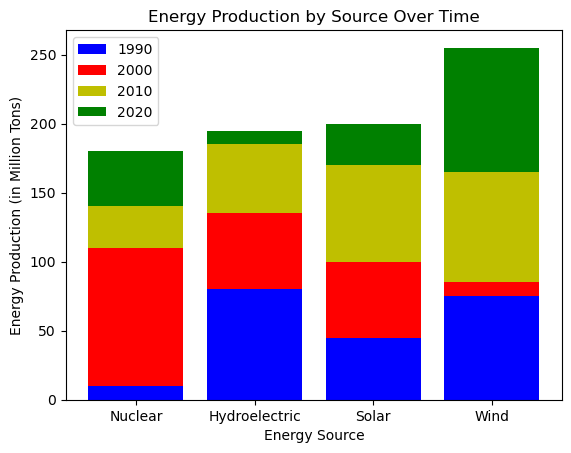

 20%|██████████████████████████                                                                                                        | 1/5 [00:21<01:24, 21.07s/it]

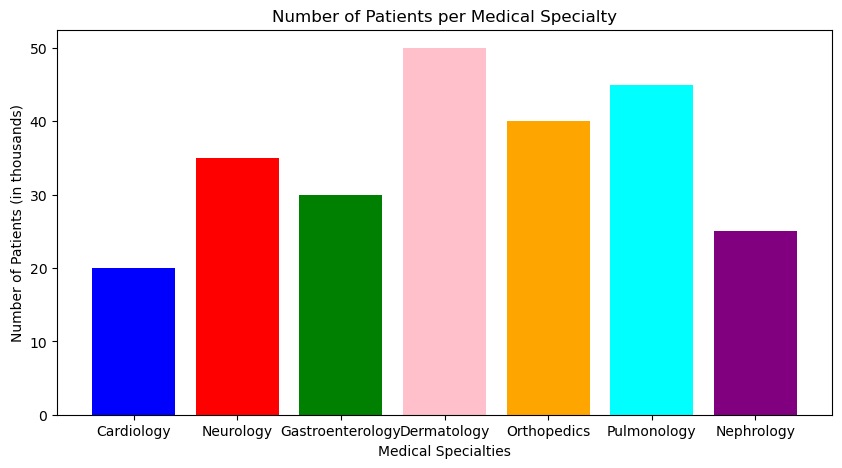

 40%|████████████████████████████████████████████████████                                                                              | 2/5 [00:41<01:01, 20.59s/it]

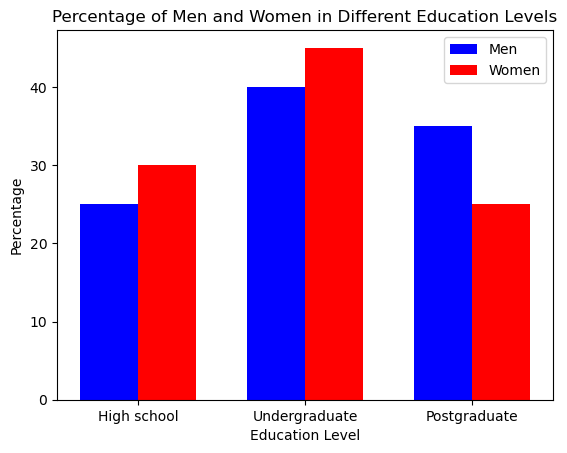

 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 3/5 [00:57<00:36, 18.44s/it]

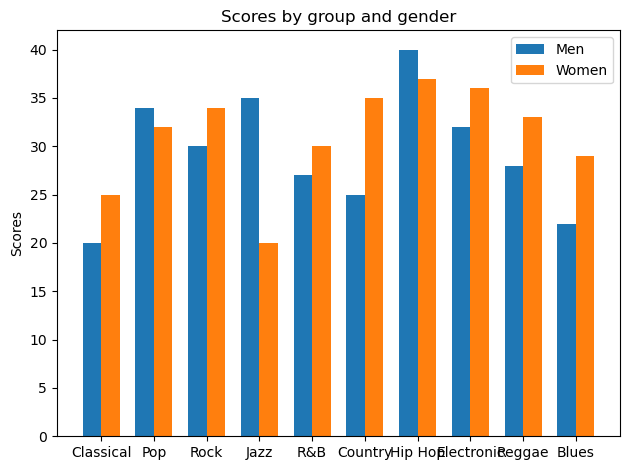

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4/5 [01:11<00:16, 16.90s/it]

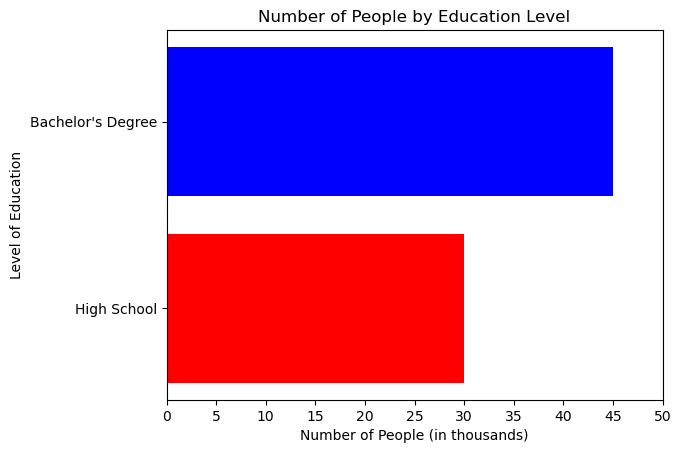

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:25<00:00, 17.07s/it]


In [20]:
#TODO: set num samples
num_samples = 5
client = OpenAI()

responses = []
for i in tqdm(range(num_samples)):
    bar_chart_type = random.choice(["horizontal bar chart", "stacked bar chart", "bar chart", "grouped bar chart"])
    num_categories = random.randint(1, 10)
    topic = random.choice(["Cities","Animals","Dog","Cat","Toys","Weather","Grades","Land","Water","Books","Paintings",
                           "Technology","Computer","Phone","Birds","Countries","Sports","Movies","Music","Food","Cars",
                           "Plants","Health","Education","Employment","Income","Hobbies","Travel","Transportation",
                           "Internet Usage","Energy Sources","Population Growth","Housing","Environmental Issues",
                           "Fashion","Fitness","Historical Events","Languages","Festivals","Gaming","Social Media",
                           "Literature","Architecture","Medicine","Politics","Space Exploration","Economy","Crime Rates",
                           "Wildlife Conservation","Natural Disasters","Real Estate","Global Warming","Agriculture",
                           "Fishing","Forestry","Retail","Advertising","Tourism","Charity","Public Opinion Polls"
    ]
    )
    question_type = random.choice(["multiple choice", "yes or no"])
    image_path = f"bar_charts/{i}.png"
    response = client.chat.completions.create(
      model="gpt-4",
      messages=[
        {
          "role": "system",
          "content": "You are a fantastic python programmer writing code to generate Matplotlib bar charts given the constraints, and also a relevant math problem and final answer."
        },
        {
          "role": "user",
          "content": f"""Write a python program that uses matplotlib to create a {bar_chart_type} with {num_categories} categories. 
          The topic of the bar chart should be {topic}, and any values in the chart must be a round number. 
          I.e., values like 17, 18, or 19 are hard to read in a chart that has axis marks every 5 numbers, 
          so values rounded to the nearest 5 would be helpful in this case. Make any labels/category titles on the chart relevant 
          to the topic. Make a plt.savefig('{image_path}') call in the code as well. Create one singular {question_type} question 
          related to the chart. Demark this question with <<<QUESTION>> at the beginning. 
          Write the answer options in a one-line python list demarked at the beginning by <<<CHOICES>>>. 
          After the python list, add <<<CHOICES>>> to mark the end of the choices.
          Reason step-by-step about your question. Write ONLY the final numerical answer for that question preceeded by the token 'Answer:'. """
        }
      ]
    )
    responses.append(response.choices[0].message.content)

    question, answer, choices = extract_question_and_answer(response.choices[0].message.content)
    if question != None and answer != None and choices != None:
        code = extract_code(response.choices[0].message.content)
        if code:
            ipython = get_ipython()
            if ipython:
                ipython.run_cell(code)
            else:
                exec(code, globals())
            
            # Load an image file
            image = Image.open(image_path)
            
            # Convert the image to a byte array
            buffered = io.BytesIO()
            image.save(buffered, format="PNG")  # You can change the format as needed
            img_bytes = buffered.getvalue()
            
            # Encode the byte array to a Base64 string
            img_str = base64.b64encode(img_bytes).decode('utf-8')

            data_to_append = {
                "question": question,
                "answer": answer,
                "choices": choices,
                "image": image_path,
                "decoded_image": img_str
            }
            
            save_to_json_file(json_file_path, data_to_append)